<a href="https://colab.research.google.com/github/tronghieu2810/DEEP-LEARNING/blob/main/UDEMY/%5BMike_X_Cohen%5D_Deep_understanding/transferlearning/DUDL_transfer_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [2]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Import a dataset

In [3]:
# Transformations
transform = T.Compose([T.ToTensor(),    # Normalizes to range [0, 1]
                       T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) # Further normalization

# Import the data and simultaneously apply the transform
train_data_set = torchvision.datasets.STL10(root='./data', download=True, split='train', transform=transform)
test_data_set  = torchvision.datasets.STL10(root='./data', download=True, split='test',  transform=transform)

# Translate into Dataloader objects
batch_size   = 32
train_loader = DataLoader(dataset=train_data_set, batch_size=batch_size,
                        shuffle=True, drop_last=True)
test_loader  = DataLoader(dataset=test_data_set, 
                        batch_size=256)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [5]:
# Shape of the datasets
print(f'Data shapes (train/test):\n {train_data_set.data.shape}\n {test_data_set.data.shape}\n')
# Range of pixel intensity values
print(f'Data value range: {np.min(train_data_set.data)} -> {np.max(train_data_set.data)}\n')
# The unique categories
print(f'Data categories: {train_data_set.classes}')

Data shapes (train/test):
 (5000, 3, 96, 96)
 (8000, 3, 96, 96)

Data value range: 0 -> 255

Data categories: ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


In [6]:
# Uh oh! It looks like the images are the wrong dimensions!
# They need to be 3x96x96
# And they are not normalized!

# but...
X,y = next(iter(train_loader))

# try again
print('Data shapes (train/test):')
print( X.data.shape )

# and the range of pixel intensity values
print('\nData value range:')
print( (torch.min(X.data),torch.max(X.data)) )

Data shapes (train/test):
torch.Size([32, 3, 96, 96])

Data value range:
(tensor(-2.1179), tensor(2.6400))


In [ ]:
# histogram of the data
plt.hist(X.data.numpy().flatten(),100);

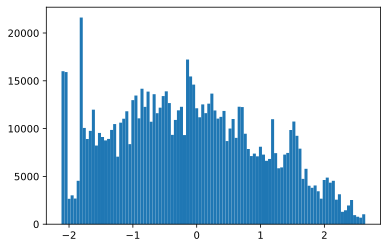

In [8]:
# Histogram of the data
plt.hist(X.data.numpy().flatten(), 100);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

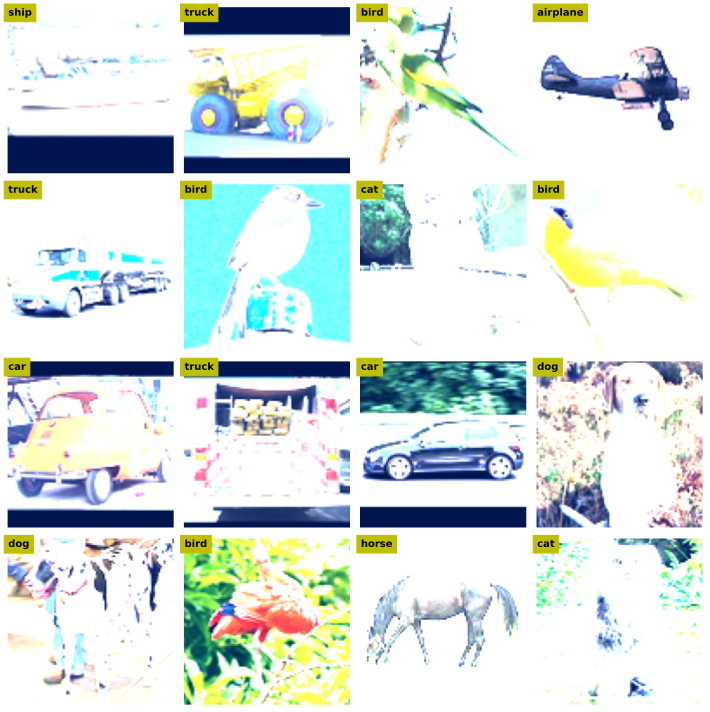

In [10]:
# INSPECT A FEW RANDOM IMAGES
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for (i, ax) in enumerate(axs.flatten()):
    # Extract that image (need to transpose it back to 32*32*3)
    pic = X.data[i].numpy().transpose((1, 2, 0))
    pic = pic - np.min(pic)
    pit = pic / np.max(pic)

    label = train_data_set.classes[y[i]]

    ax.imshow(pic)
    ax.text(0, 0, label, ha='left', va='top', fontweight='bold', color='k', backgroundcolor='y')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Import and inspect the resnet model

In [11]:
resnet = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [12]:
# let's inspect this network
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
from torchsummary import summary
summary(resnet.to(device), (3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          36,864
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,864
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
       BasicBlock-11           [-1, 64, 24, 24]               0
           Conv2d-12           [-1, 64, 24, 24]          36,864
      BatchNorm2d-13           [-1, 64, 24, 24]             128
             ReLU-14           [-1, 64,

In [14]:
# Freeze all layers
for p in resnet.parameters():
    p.requires_grad = False

# Change the final layer
resnet.fc = nn.Linear(512, 10)

# Push the model to the GPU
resnet.to(device);

# Train the model

In [15]:
## TRAIN THE MODEL
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

In [18]:
num_epochs = 10

# Initialize
train_loss = torch.zeros(num_epochs)
test_loss  = torch.zeros(num_epochs)
train_acc  = torch.zeros(num_epochs)
test_acc   = torch.zeros(num_epochs)

# Loop over epochs
for epoch_i in range(num_epochs):
    
    resnet.train()

    # Loop over training data batches
    batch_acc  = []
    batch_loss = [] 

    for X, y in train_loader:
        # Push data to GPU
        X = X.to(device)
        y = y.to(device)

        # Forward pass and loss
        y_hat = resnet(X)
        loss  = loss_func(y_hat,y)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Loss from this batch
        batch_loss.append(loss.item())
        batch_acc .append(torch.mean((torch.argmax(y_hat,axis=1) == y).float()).item())

    # End of batch loop.

    # Get the average training accuracy of the batches
    train_loss[epoch_i] = np.mean(batch_loss)
    train_acc [epoch_i] = 100 * np.mean(batch_acc)

    # Test accuracy
    resnet.eval()
    batch_acc  = []
    batch_loss = []

    for X, y in test_loader:
        
        X = X.to(device)
        y = y.to(device)

        with torch.no_grad():
            y_hat = resnet(X)
            loss  = loss_func(y_hat, y)
        
        batch_loss.append(loss.item())
        batch_acc .append(torch.mean((torch.argmax(y_hat,axis=1) == y).float()).item())

    test_loss[epoch_i] = np.mean(batch_loss)
    test_acc [epoch_i] = 100 * np.mean(torch.mean((torch.argmax(y_hat,axis=1) == y).float()).item())

    print(f'Finished epoch {epoch_i + 1} / {num_epochs}. Test accuracy = {test_acc[epoch_i]:.2f}')

Finished epoch 1 / 10. Test accuracy = 70.31
Finished epoch 2 / 10. Test accuracy = 76.56
Finished epoch 3 / 10. Test accuracy = 76.56
Finished epoch 4 / 10. Test accuracy = 68.75
Finished epoch 5 / 10. Test accuracy = 76.56
Finished epoch 6 / 10. Test accuracy = 71.88
Finished epoch 7 / 10. Test accuracy = 71.88
Finished epoch 8 / 10. Test accuracy = 73.44
Finished epoch 9 / 10. Test accuracy = 76.56
Finished epoch 10 / 10. Test accuracy = 73.44


# Visualize the performance

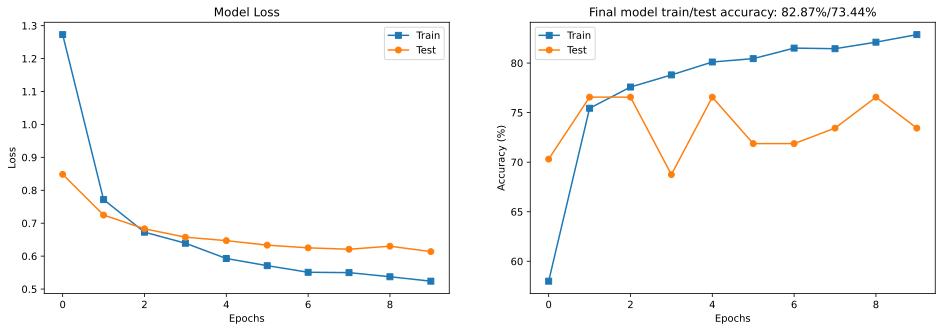

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(train_loss, 's-', label='Train')
ax[0].plot(test_loss,  'o-', label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')
ax[0].legend()

ax[1].plot(train_acc, 's-', label='Train')
ax[1].plot(test_acc,  'o-', label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train/test accuracy: {train_acc[-1]:.2f}%/{test_acc[-1]:.2f}%')
ax[1].legend()

plt.show()

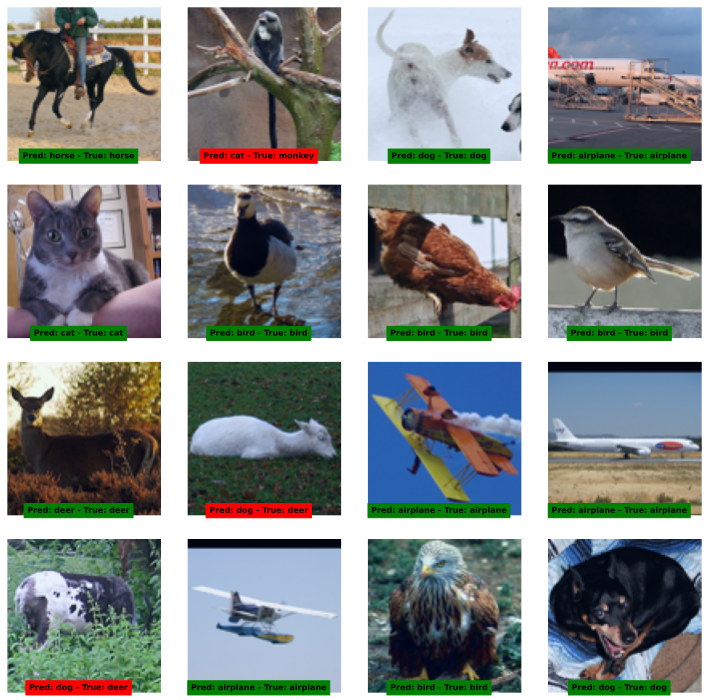

In [23]:
# Inspect a few random images
X, y = next(iter(test_loader))
X = X.to(device)
y = y.to(device)
resnet.eval()
predictions = torch.argmax(resnet(X), axis=1)

fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for (i, ax) in enumerate(axs.flatten()):
    # Extract image
    pic = X.data[i].cpu().numpy().transpose((1, 2, 0))
    pic = pic - np.min(pic)
    pic = pic / np.max(pic)

    ax.imshow(pic)

    label = train_data_set.classes[predictions[i]]
    truec = train_data_set.classes[y[i]]
    title = f'Pred: {label} - True: {truec}'

    # Set the title with color-coded accuracy
    title_color = 'g' if (truec == label) else 'r'
    ax.text(44, 90, title, ha='center', va='top', fontweight='bold', color='k', backgroundcolor=title_color, fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# 1) Try re-downloading the resnet18, unfreeze the layers, and re-run. This means you'll be fine-tuning the entire
#    network instead of only the final prediction layer.
# 
# 2) Download an untrained resnet18. This is simply the architecture with random weights (you'll still need to replace
#    the final layer so it has 10 outputs). Train this model; how is the performance?
# 
# 3) I used SGD as the backprop method. Try re-running the analysis using Adam. Does this help or hurt the train and
#    test performance?
# 
# 4) ~80% accuracy is pretty decent considering we didn't do anything to optimize the model. Looking through the model
#    metaparameters, what are some things you would try to change if you wanted to boost performance?
# 
# 5) You've seen earlier in the course that data normalization is important. This is particularly so for pretrained 
#    networks, because the weights are tuned to specific numerical ranges. But how important is the *exact* numerical 
#    range? To find out, re-run the code but remove the normalization transform. Thus, the images now will be in the 
#    range [0,1], which is overlapping with but smaller than (and non-negative) the range that the network is trained on.
# 